# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from scipy.io import wavfile
import scipy.signal
from PIL import Image
import shutil

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
#import noisereduce as nr
from imblearn.over_sampling import SMOTE
from scipy.signal import lfilter, butter
#import keras_tuner as kt
#from kerastuner import HyperModel
#from keras_tuner import RandomSearch

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
#from hmmlearn import hmm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from scipy.stats import uniform, randint
from keras import optimizers
from keras import losses


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras import regularizers
from sklearn.neural_network import MLPClassifier
from keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras import layers, models
from tensorflow.keras.layers import SimpleRNN
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.layers import  Bidirectional,RepeatVector, TimeDistributed
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

from keras.layers import BatchNormalization, Reshape, Multiply,Conv2D, MaxPooling2D

# **Import Dataset**

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive (7).zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
## Create a dataframe
df1 = pd.DataFrame()
df1['speech'] = paths
df1['label'] = labels
df1.head()

,speech,label
0,/content/TESS Toronto emotional speech set dat...,happy
1,/content/TESS Toronto emotional speech set dat...,happy
2,/content/TESS Toronto emotional speech set dat...,happy
3,/content/TESS Toronto emotional speech set dat...,happy
4,/content/TESS Toronto emotional speech set dat...,happy


In [ ]:
df = df1.sample(frac=1).reset_index(drop=True)
df.head()

,speech,label
0,/content/TESS Toronto emotional speech set dat...,angry
1,/content/TESS Toronto emotional speech set dat...,ps
2,/content/TESS Toronto emotional speech set dat...,ps
3,/content/TESS Toronto emotional speech set dat...,ps
4,/content/TESS Toronto emotional speech set dat...,angry


# **Preprocessing and feature extraction**

In [ ]:
import random

In [ ]:
# Define preprocessing parameters
TARGET_SAMPLE_RATE = 48000   # Desired sample rate for resampling
FRAME_SIZE = 1200            # Frame size in samples (25 ms)
HOP_LENGTH = 600             # Hop length in samples (50% overlap)
MFCC_N_MFCC = 13             # Number of MFCC coefficients to extract
PAD_LENGTH = 5 * TARGET_SAMPLE_RATE

In [ ]:
def preprocess_audio(file_path, target_sr=TARGET_SAMPLE_RATE, pad_length=PAD_LENGTH):
    # Step 1: Load the audio and resample it to the target sample rate
    y, sr = librosa.load(file_path, sr=target_sr)

    # Step 2: Normalize the audio (Peak normalization to [-1, 1] range)
    y = librosa.util.normalize(y)

    # Step 3: Silence Removal (Using librosa.effects.trim)
    y, _ = librosa.effects.trim(y)

    # Step 4: Padding (if the audio is shorter than the target length)
    if len(y) < pad_length:
        padding = pad_length - len(y)
        y = np.pad(y, (0, padding), 'constant')  # Zero padding at the end

    return y, target_sr

In [ ]:
# Function to extract raw MFCC features
def extract_mfcc(audio, sr, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, n_mfcc=MFCC_N_MFCC):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)

    return mfcc

In [ ]:
# Helper function to pad or truncate features
def pad_or_truncate(features, target_length):
    # If the number of frames is less than the target, pad with zeros
    if features.shape[1] < target_length:
        padding = target_length - features.shape[1]
        return np.pad(features, ((0, 0), (0, padding)), mode='constant')
    # If the number of frames is more than the target, truncate
    elif features.shape[1] > target_length:
        return features[:, :target_length]
    return features

In [ ]:
# Initialize list to store processed data
processed_data = []
target_num_frames = 400  # Set a target number of frames for padding/truncating
scaler = StandardScaler()  # Initialize the scaler

# Assuming df1 is already defined and contains the audio paths and labels
for index, row in df.iterrows():
    audio_path = row['speech']
    label = row['label']

    # Preprocess the audio
    y, sr = preprocess_audio(audio_path)

    # Extract raw MFCC features (shape: (n_mfcc, num_frames))
    raw_mfcc = extract_mfcc(y, sr)

    # Pad or truncate MFCC features to ensure consistent number of frames
    adjusted_mfcc = pad_or_truncate(raw_mfcc, target_num_frames)

    # Transpose the MFCC array to fit the (num_frames, num_mfcc) format
    adjusted_mfcc = adjusted_mfcc.T

    # Normalize each frame's MFCCs (standardize)
    scaled_mfcc = scaler.fit_transform(adjusted_mfcc)

    # Append the scaled features and label to processed_data
    processed_data.append((scaled_mfcc, label))


In [ ]:
# Create separate lists for features and labels
X = [item[0] for item in processed_data]  # List of feature arrays (MFCCs)
y = [item[1] for item in processed_data]  # Corresponding labels

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Apply one-hot encoding to the labels
encoder = OneHotEncoder(sparse_output=False)  # Updated parameter
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Now, X has shape (num_samples, num_frames, num_mfcc), and y_onehot is one-hot encoded
print("X shape:", X.shape)        # Expected: (num_samples, num_frames, num_mfcc)
print("y_onehot shape:", y_onehot.shape)


X shape: (2800, 400, 13)
y_onehot shape: (2800, 7)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

# Now X_train and X_test contain the MFCC features, and y_train and y_test contain one-hot encoded labels
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2240, 400, 13)
X_test shape: (560, 400, 13)
y_train shape: (2240, 7)
y_test shape: (560, 7)


In [ ]:

# Input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (num_frames, num_mfcc)
print("Input shape:", input_shape)

# Number of classes
num_classes = y_train.shape[1]  # Number of unique classes
print("Number of classes:", num_classes)

Input shape: (400, 13)
Number of classes: 7


# **Plot**

In [ ]:
# Define functions for augmentations
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def time_stretch(y, stretch_rate=1.1):
    return librosa.effects.time_stretch(y, rate=stretch_rate)

def pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def volume_control(y, gain=1.1):
    return y * gain

# Load the audio file
audio_path = '/content/Actor_01/03-01-01-01-01-01-01.wav'
y, sr = librosa.load(audio_path, sr=48000)

# Plot comparison functions
def plot_waveform_comparison(y1, y2, sr, title1, title2):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y1, sr=sr, color='blue')
    plt.title(title1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.subplot(1, 2, 2)
    librosa.display.waveshow(y2, sr=sr, color='blue')
    plt.title(title2)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

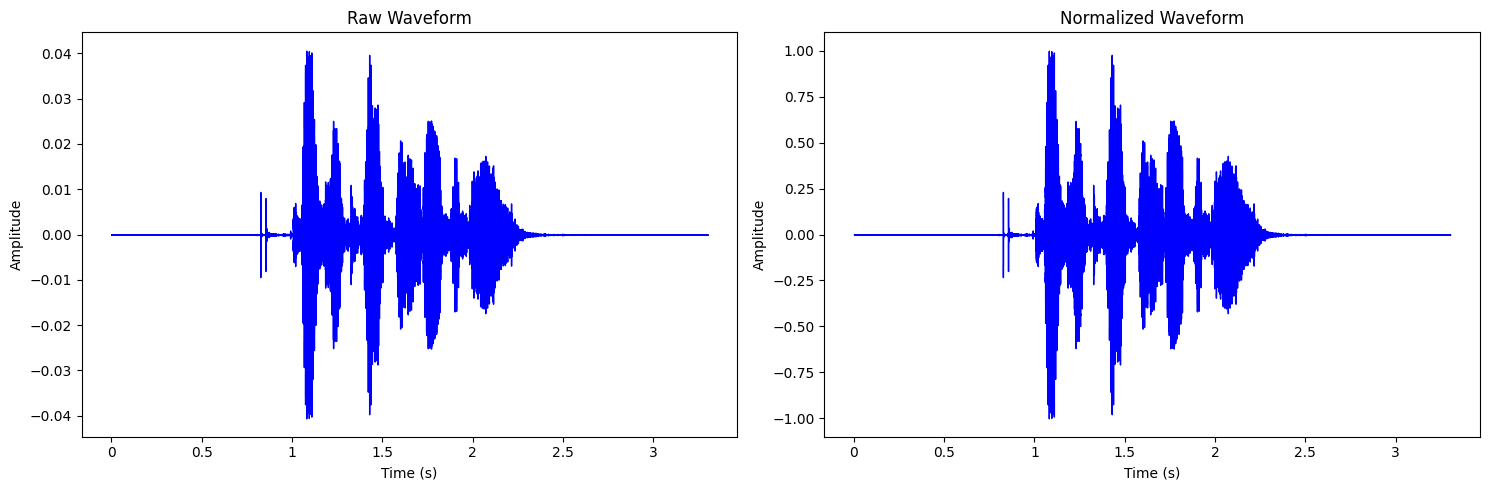

Original length: 158558, Trimmed length: 110558


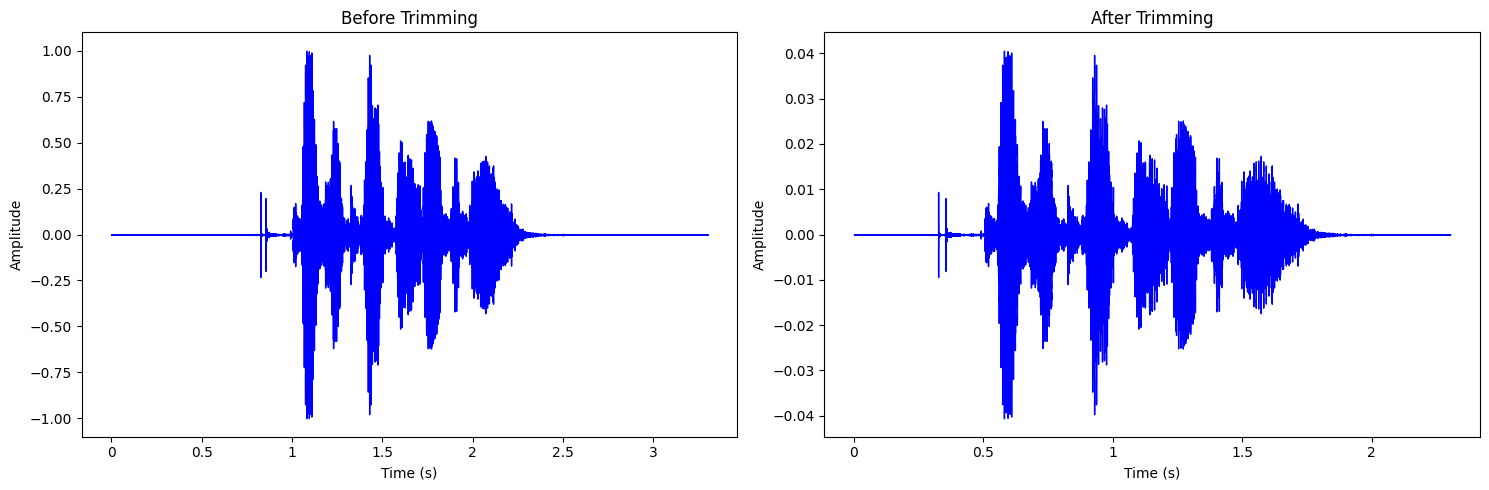

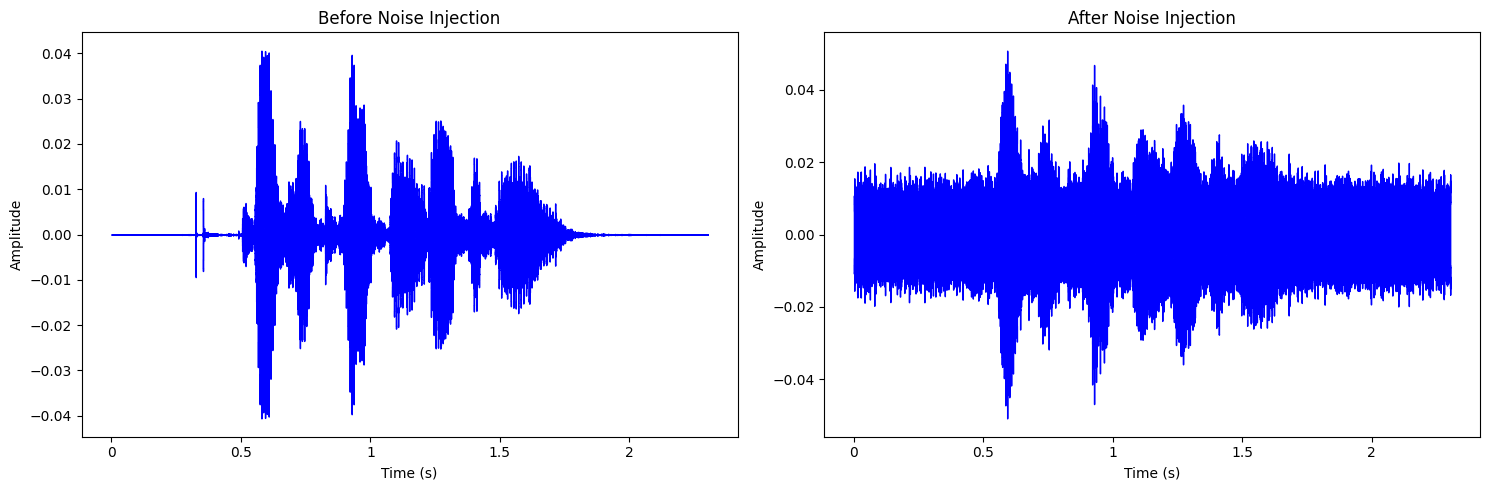

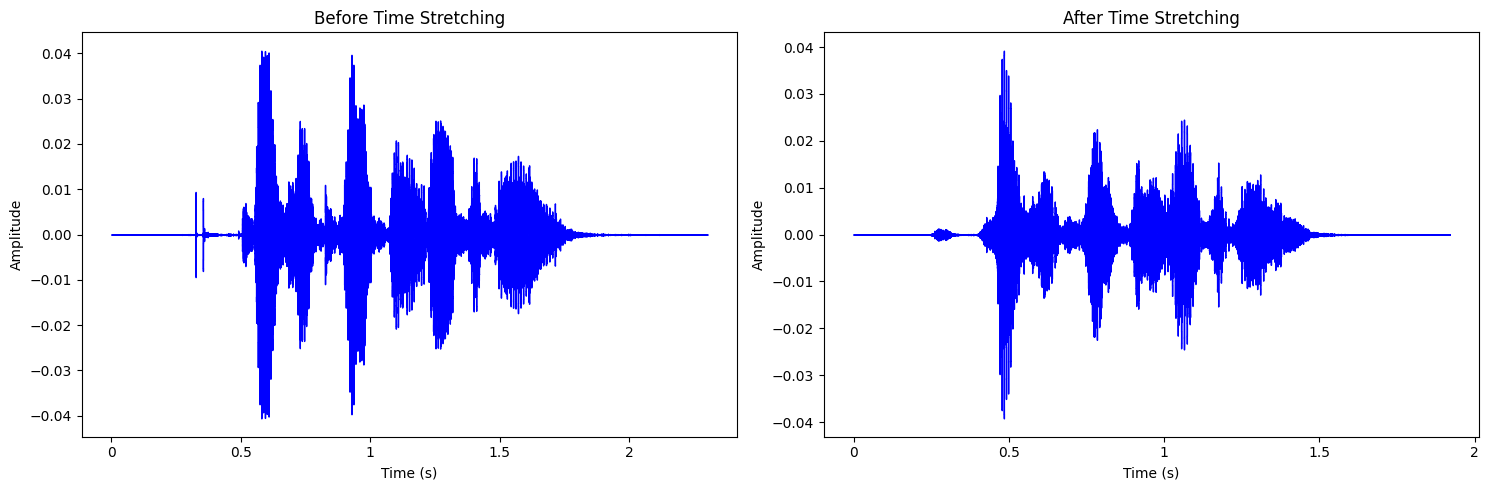

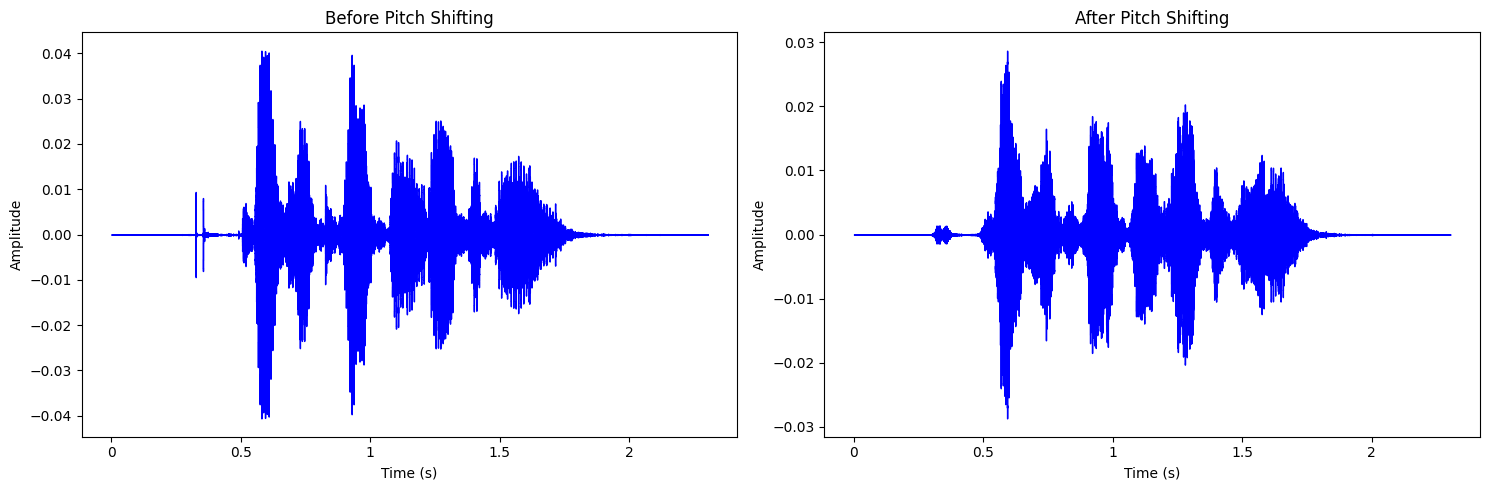

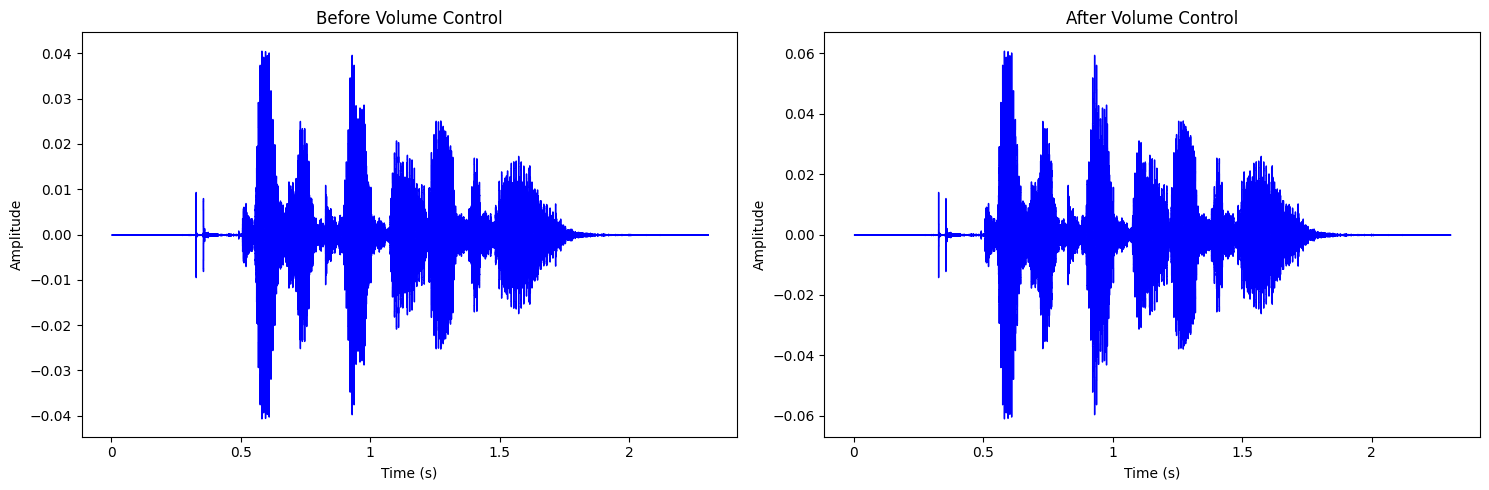

In [ ]:
# Raw vs. Normalized
y_normalized = librosa.util.normalize(y)
plot_waveform_comparison(y, y_normalized, sr, "Raw Waveform", "Normalized Waveform")

# Calculate the number of samples for 0.5 seconds
trim_duration = int(0.5 * sr)

# Trim the first and last 0.5 seconds
y_trimmed = y[trim_duration:-trim_duration]

# Check results
print(f"Original length: {len(y)}, Trimmed length: {len(y_trimmed)}")

plot_waveform_comparison(y_normalized, y_trimmed, sr, "Before Trimming", "After Trimming")

# Before and After Noise Injection
y_noisy = add_noise(y_trimmed)
plot_waveform_comparison(y_trimmed, y_noisy, sr, "Before Noise Injection", "After Noise Injection")

# Before and After Time Stretching
y_stretched = time_stretch(y_trimmed, stretch_rate=1.2)
plot_waveform_comparison(y_trimmed, y_stretched, sr, "Before Time Stretching", "After Time Stretching")

# Before and After Pitch Shifting
y_pitched = pitch_shift(y_trimmed, sr, n_steps=4)
plot_waveform_comparison(y_trimmed, y_pitched, sr, "Before Pitch Shifting", "After Pitch Shifting")

# Before and After Volume Control
y_volume = volume_control(y_trimmed, gain=1.5)
plot_waveform_comparison(y_trimmed, y_volume, sr, "Before Volume Control", "After Volume Control")


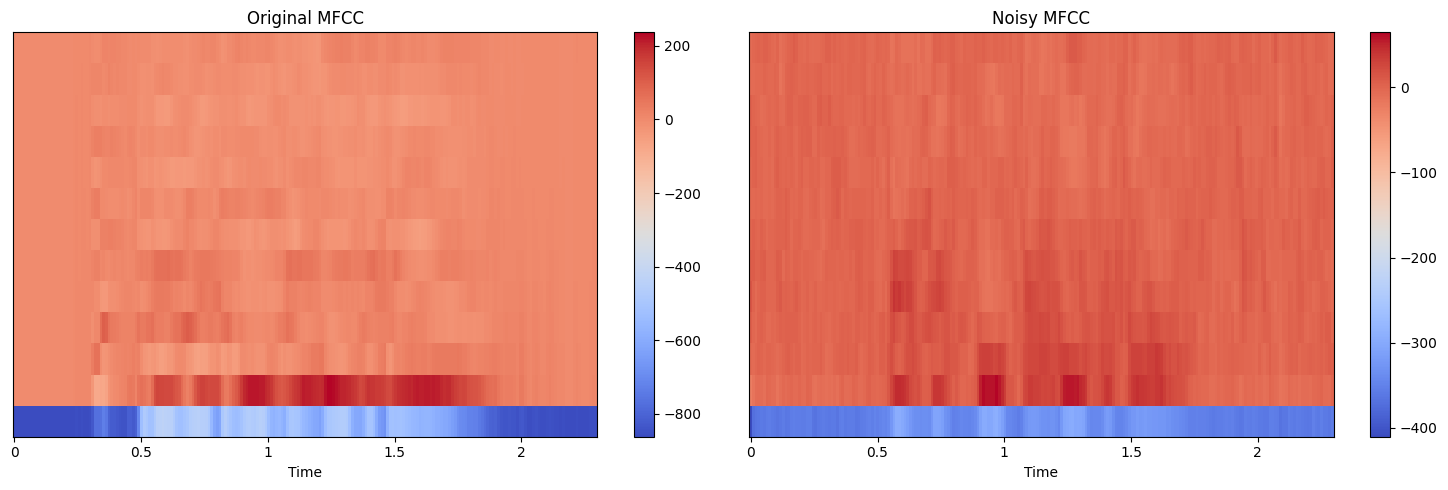

In [ ]:
# MFCC Visualization
def plot_mfcc_comparison(y1, y2, sr, title1, title2):
    mfcc1 = librosa.feature.mfcc(y=y1, sr=sr, n_mfcc=13)
    mfcc2 = librosa.feature.mfcc(y=y2, sr=sr, n_mfcc=13)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfcc1, sr=sr, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title(title1)

    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc2, sr=sr, x_axis='time', cmap='coolwarm')
    plt.colorbar()
    plt.title(title2)

    plt.tight_layout()
    plt.show()

# Compare MFCCs: Original vs. Noisy
plot_mfcc_comparison(y_trimmed, y_noisy, sr, "Original MFCC", "Noisy MFCC")

# **LSTM with one attention laeyr**

In [ ]:
from tensorflow.keras.layers import Layer,Dot, Activation, Concatenate


In [ ]:
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(input_shape, num_classes):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))


    model.add(LSTM(128))




    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)  # Clip gradients
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Model summary
model_with_lstm_attention = build_lstm_attention_model(input_shape, num_classes)
model_with_lstm_attention.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 400, 512)            │       1,077,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,418,823 (5.41 MB)

 Trainable params: 1,418,567 (5.41 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    patience=15,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [ ]:
# Train the model with early stopping
history_lstm = model_with_lstm_attention.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.3582 - loss: 1.7628 - val_accuracy: 0.1652 - val_loss: 1.8212
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6246 - loss: 1.0079 - val_accuracy: 0.3259 - val_loss: 1.6210
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7049 - loss: 0.8183 - val_accuracy: 0.2411 - val_loss: 1.6264
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7688 - loss: 0.6388 - val_accuracy: 0.3817 - val_loss: 1.5776
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7836 - loss: 0.6109 - val_accuracy: 0.4040 - val_loss: 1.4312
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7608 - loss: 0.6396 - val_accuracy: 0.5268 - val_loss: 1.2447
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8194 - loss: 0.5265 - val_accuracy: 0.5647 - val_loss: 1.0324
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.7990 - loss: 0.5580 - val_acc

###**Model evaluation**

In [ ]:
# Predict the labels for the test set
y_pred = model_with_lstm_attention.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [ ]:
# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9000


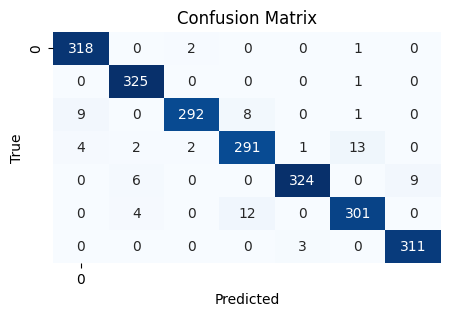

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=8, yticklabels=8)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
class_labels = ['01', '02', '03', '04', '05', '06', '07']

In [ ]:
# Classification report (Precision, Recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

          01       0.96      0.99      0.98       321
          02       0.96      1.00      0.98       326
          03       0.99      0.94      0.96       310
          04       0.94      0.93      0.93       313
          05       0.99      0.96      0.97       339
          06       0.95      0.95      0.95       317
          07       0.97      0.99      0.98       314

    accuracy                           0.97      2240
   macro avg       0.97      0.96      0.96      2240
weighted avg       0.97      0.97      0.97      2240



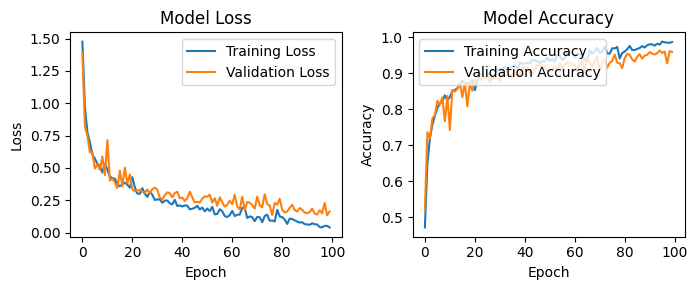

In [ ]:
# Plotting Loss and Accuracy
def plot_loss_and_accuracy(history):
    # Plot training & validation loss values
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_loss_and_accuracy(history_lstm)

In [ ]:
# Model summary
model_with_lstm_smote_attention = build_lstm_attention_model(input_shape, num_classes)
model_with_lstm_smote_attention.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 400, 512)            │       1,077,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 400, 128)            │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 128)                 │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,419,416 (5.41 MB)

 Trainable params: 1,419,160 (5.41 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Training the model with attention
lstm_history = model_with_lstm_smote_attention.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.2508 - loss: 2.2360 - val_accuracy: 0.2960 - val_loss: 1.9834
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.5091 - loss: 1.3784 - val_accuracy: 0.3819 - val_loss: 1.7646
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.6311 - loss: 1.0357 - val_accuracy: 0.4488 - val_loss: 1.4708
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.7401 - loss: 0.7594 - val_accuracy: 0.7161 - val_loss: 0.9807
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.8049 - loss: 0.5612 - val_accuracy: 0.8116 - val_loss: 0.5992
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.8806 - loss: 0.3810 - val_accuracy: 0.7717 - val_loss: 0.6065
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9031 - loss: 0.3035 - val_accuracy: 0.8273 - val_loss: 0.5290
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9240 - loss: 0.2446 - v

# **GRU with one attention layer**

In [ ]:
def build_gru_attention_model(input_shape, num_classes):
    model = Sequential()

    # Add GRU layers
    model.add(GRU(512, return_sequences=True, input_shape=input_shape))


    model.add(GRU(128))




    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)  # Clip gradients
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Model summary
model_with_gru_attention = build_gru_attention_model(input_shape, num_classes)
model_with_gru_attention.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 400, 512)            │         809,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │         246,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,069,383 (4.08 MB)

 Trainable params: 1,069,127 (4.08 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Train the model with early stopping
history_gru = model_with_gru_attention.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
      # Add the callback here
)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.3647 - loss: 1.8243 - val_accuracy: 0.4224 - val_loss: 1.4045
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5744 - loss: 1.1315 - val_accuracy: 0.4554 - val_loss: 1.4114
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.6764 - loss: 0.8445 - val_accuracy: 0.7963 - val_loss: 0.5532
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.8352 - loss: 0.4927 - val_accuracy: 0.8672 - val_loss: 0.3967
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.8969 - loss: 0.3178 - val_accuracy: 0.9531 - val_loss: 0.1269
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9523 - loss: 0.1596 - val_accuracy: 0.9688 - val_loss: 0.0818
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9740 - loss: 0.0972 - val_accuracy: 0.9794 - val_loss: 0.0701
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9792 -

###**Model evaluation**

In [ ]:
# Predict the labels for the test set
y_pred = model_with_gru_attention.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [ ]:
# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9987


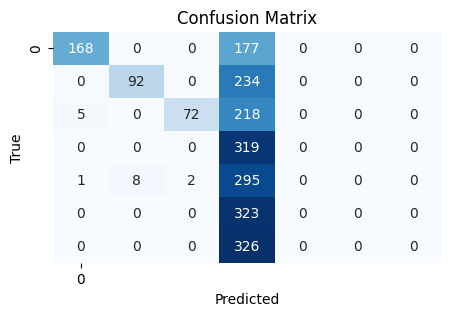

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=8, yticklabels=8)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Classification report (Precision, Recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

          01       0.97      0.49      0.65       345
          02       0.92      0.28      0.43       326
          03       0.97      0.24      0.39       295
          04       0.17      1.00      0.29       319
          05       0.00      0.00      0.00       306
          06       0.00      0.00      0.00       323
          07       0.00      0.00      0.00       326

    accuracy                           0.29      2240
   macro avg       0.43      0.29      0.25      2240
weighted avg       0.43      0.29      0.26      2240



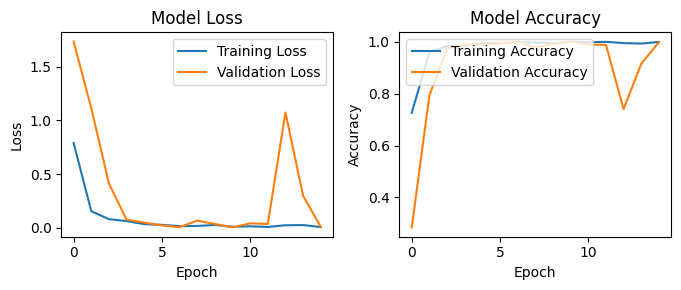

In [ ]:
# Plotting Loss and Accuracy
def plot_loss_and_accuracy(history):
    # Plot training & validation loss values
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_loss_and_accuracy(history_gru)

# **BLSTM with one attention layer**

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
def build_bilstm_attention_model(input_shape, num_classes):
    model = Sequential()

    # Add Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(128)))


    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)  # Clip gradients to prevent exploding gradients
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Model summary
model_with_blstm_attention = build_bilstm_attention_model(input_shape, num_classes)
model_with_blstm_attention.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 400, 1024)           │       2,154,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,356,743 (12.80 MB)

 Trainable params: 3,356,487 (12.80 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Train the model with early stopping
history_attention = model_with_blstm_attention.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.3726 - loss: 1.8094 - val_accuracy: 0.4442 - val_loss: 1.7034
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.7464 - loss: 0.7304 - val_accuracy: 0.6585 - val_loss: 1.2749
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - accuracy: 0.8501 - loss: 0.4419 - val_accuracy: 0.8103 - val_loss: 1.0791
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.9174 - loss: 0.2952 - val_accuracy: 0.7500 - val_loss: 0.8361
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 300ms/step - accuracy: 0.9158 - loss: 0.2977 - val_accuracy: 0.9420 - val_loss: 0.3938
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.9556 - loss: 0.1561 - val_accuracy: 0.9688 - val_loss: 0.2510
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.9586 - loss: 0.1553 - val_accuracy: 0.9665 - val_loss: 0.1535
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.9737 - loss: 0.1223 - v

### **Model evaluation**

In [ ]:
# Predict the labels for the test set
y_pred = model_with_blstm_attention.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


In [ ]:
# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9982


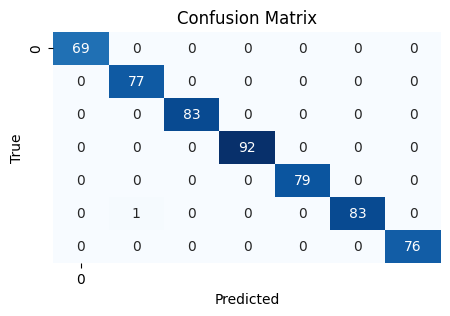

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=8, yticklabels=8)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Classification report (Precision, Recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print('Classification Report:\n', report)

NameError: name 'class_labels' is not defined

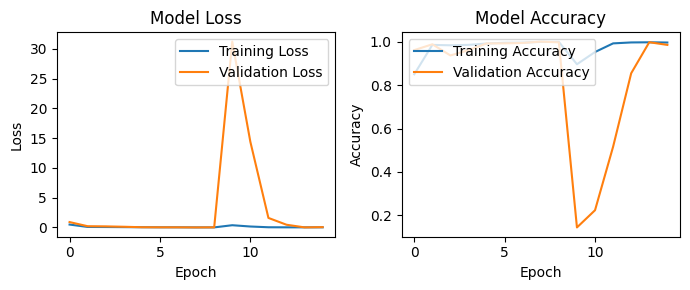

In [ ]:
# Plotting Loss and Accuracy
def plot_loss_and_accuracy(history):
    # Plot training & validation loss values
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_loss_and_accuracy(history_attention)